# Introduction

Notebook to aggregate the running of models in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Union Strategy

In [2]:
models_runner_1 = Feat_BR_Models_Runner()
lsi_model_1 = models_runner_1.run_lsi_model()
lda_model_1 = models_runner_1.run_lda_model()
bm25_model_1 = models_runner_1.run_bm25_model()
w2v_model_1 = models_runner_1.run_word2vec_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)
evals_df_1 = evaluator_1.run_evaluator(models=[lsi_model_1,lda_model_1,bm25_model_1,w2v_model_1])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix UNION.shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [3]:
evals_df_1

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,42.86,33.78,36.21,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_3_cosine_0.0,25.64,54.91,33.09,precision recall fscore Bug_...,0.0,3.0,Bug_Number 1248267 1248268 125...
2,lsi,top_5_cosine_0.0,17.36,59.29,25.49,precision recall fscore Bug_...,0.0,5.0,Bug_Number 1248267 1248268 125...
3,lsi,top_10_cosine_0.0,10.55,69.55,17.48,precision recall fscore Bug_...,0.0,10.0,Bug_Number 1248267 1248268 125...
4,lda,top_1_cosine_0.0,17.58,11.94,13.55,precision recall fscore Bug_...,0.0,1.0,Bug_Number 1248267 1248268 125...
5,lda,top_3_cosine_0.0,10.26,19.11,12.53,precision recall fscore Bug_...,0.0,3.0,Bug_Number 1248267 1248268 125...
6,lda,top_5_cosine_0.0,14.73,50.88,21.74,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
7,lda,top_10_cosine_0.0,10.77,72.55,17.99,precision recall fscore Bug_Nu...,0.0,10.0,Bug_Number 1248267 1248268 125...
8,bm25,top_1_cosine_0.0,36.26,28.56,30.65,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
9,bm25,top_3_cosine_0.0,23.08,50.62,30.13,precision recall fscore Bug_...,0.0,3.0,Bug_Number 1248267 1248268 125...


### Plots

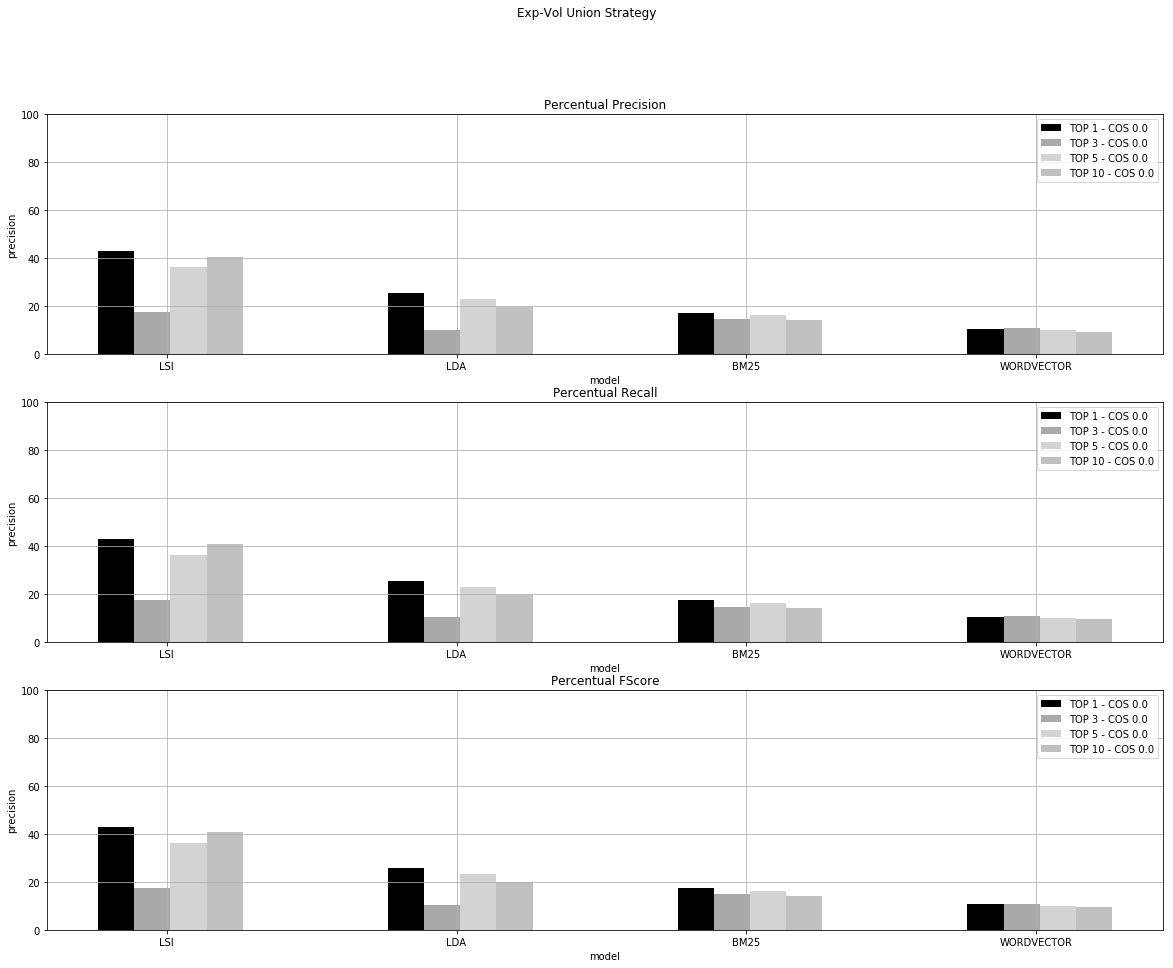

In [4]:
evaluator_1.plot_evaluations_1(evals_df=evals_df_1, title='Exp-Vol Union Strategy')

### Delete Variables

In [5]:
del lsi_model_1, lda_model_1, bm25_model_1, w2v_model_1
del evals_df_1
del models_runner_1, evaluator_1

## Intersec Strategy

In [6]:
models_runner_2 = Feat_BR_Models_Runner()
lsi_model_2 = models_runner_2.run_lsi_model()
lda_model_2 = models_runner_2.run_lda_model()
bm25_model_2 = models_runner_2.run_bm25_model()
w2v_model_2 = models_runner_2.run_word2vec_model()

evaluator_2 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_intersec_df().T)
evals_df_2 = evaluator_2.run_evaluator(models=[lsi_model_2,lda_model_2, bm25_model_2, w2v_model_2])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix INTERSEC.shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [7]:
evals_df_2

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,26.37,25.82,26.01,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_3_cosine_0.0,12.09,35.16,17.91,precision recall fscore Bug_Numb...,0.0,3.0,Bug_Number 1248267 1248268 125...
2,lsi,top_5_cosine_0.0,7.25,35.16,11.98,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
3,lsi,top_10_cosine_0.0,3.63,35.16,6.56,precision recall fscore Bug_Nu...,0.0,10.0,Bug_Number 1248267 1248268 125...
4,lda,top_1_cosine_0.0,3.30,2.75,2.93,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
5,lda,top_3_cosine_0.0,2.93,8.24,4.29,precision recall fscore Bug_Numb...,0.0,3.0,Bug_Number 1248267 1248268 125...
6,lda,top_5_cosine_0.0,5.71,27.47,9.42,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
7,lda,top_10_cosine_0.0,3.63,35.16,6.56,precision recall fscore Bug_Nu...,0.0,10.0,Bug_Number 1248267 1248268 125...
8,bm25,top_1_cosine_0.0,20.88,20.33,20.51,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
9,bm25,top_3_cosine_0.0,10.62,31.32,15.82,precision recall fscore Bug_Numb...,0.0,3.0,Bug_Number 1248267 1248268 125...


### Plots

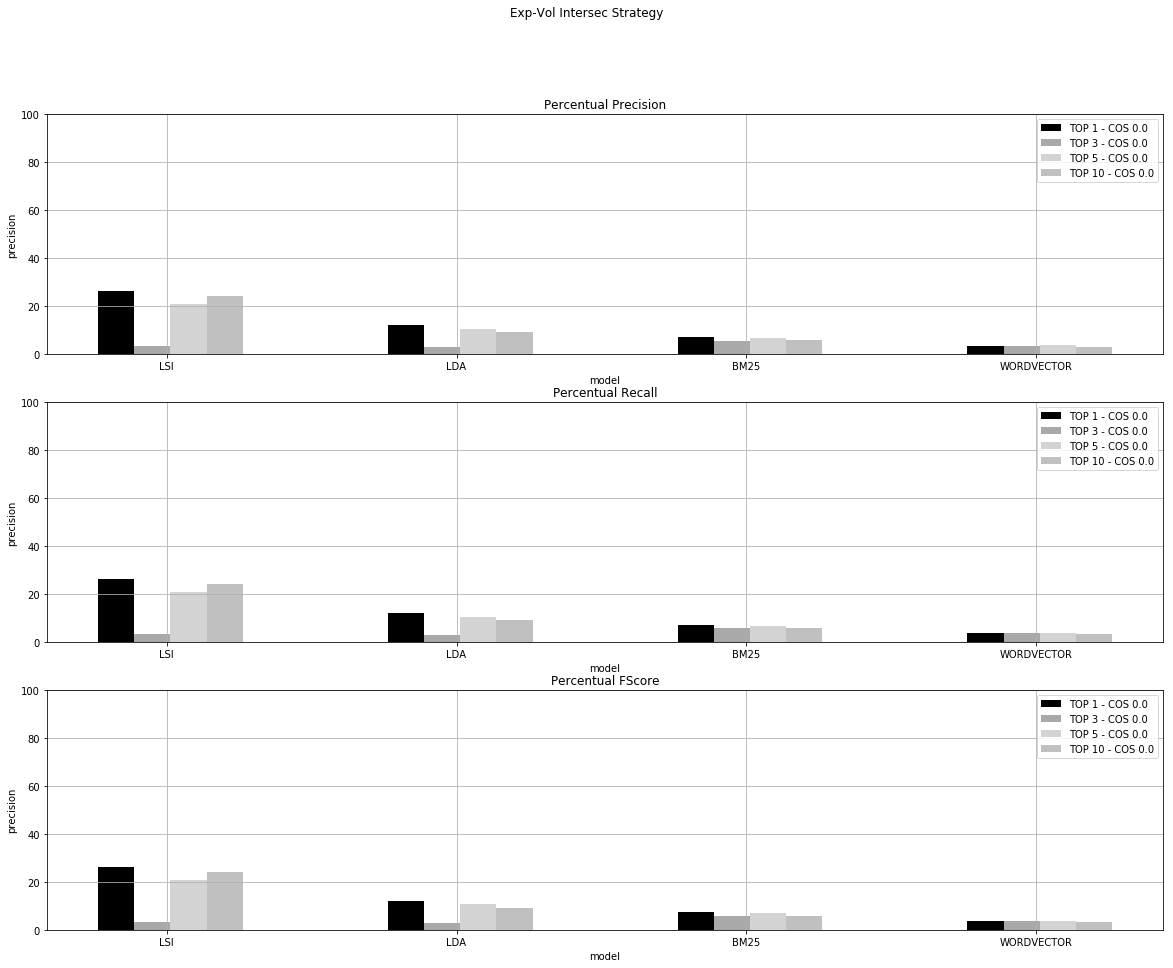

In [8]:
evaluator_2.plot_evaluations_1(evals_df=evals_df_2, title='Exp-Vol Intersec Strategy')

### Delete Variables

In [9]:
del lsi_model_2, lda_model_2, bm25_model_2, w2v_model_2
del evals_df_2
del models_runner_2, evaluator_2

## Expert Only Strategy

In [10]:
models_runner_3 = Feat_BR_Models_Runner()
lsi_model_3 = models_runner_3.run_lsi_model()
lda_model_3 = models_runner_3.run_lda_model()
bm25_model_3 = models_runner_3.run_bm25_model()
w2v_model_3 = models_runner_3.run_word2vec_model()

evaluator_3 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_df().T)
evals_df_3 = evaluator_3.run_evaluator(models=[lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Expert Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [11]:
evals_df_3

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,40.66,37.73,38.64,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_3_cosine_0.0,19.41,50.73,27.55,precision recall fscore Bug_Numb...,0.0,3.0,Bug_Number 1248267 1248268 125...
2,lsi,top_5_cosine_0.0,12.09,51.65,19.24,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
3,lsi,top_10_cosine_0.0,6.26,53.85,11.10,precision recall fscore Bug_Nu...,0.0,10.0,Bug_Number 1248267 1248268 125...
4,lda,top_1_cosine_0.0,6.59,4.40,5.13,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
5,lda,top_3_cosine_0.0,4.76,11.54,6.59,precision recall fscore Bug_Numb...,0.0,3.0,Bug_Number 1248267 1248268 125...
6,lda,top_5_cosine_0.0,8.79,39.38,14.19,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
7,lda,top_10_cosine_0.0,6.15,54.03,10.94,precision recall fscore Bug_Nu...,0.0,10.0,Bug_Number 1248267 1248268 125...
8,bm25,top_1_cosine_0.0,31.87,29.49,30.22,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
9,bm25,top_3_cosine_0.0,17.22,46.34,24.69,precision recall fscore Bug_Numb...,0.0,3.0,Bug_Number 1248267 1248268 125...


### Plots

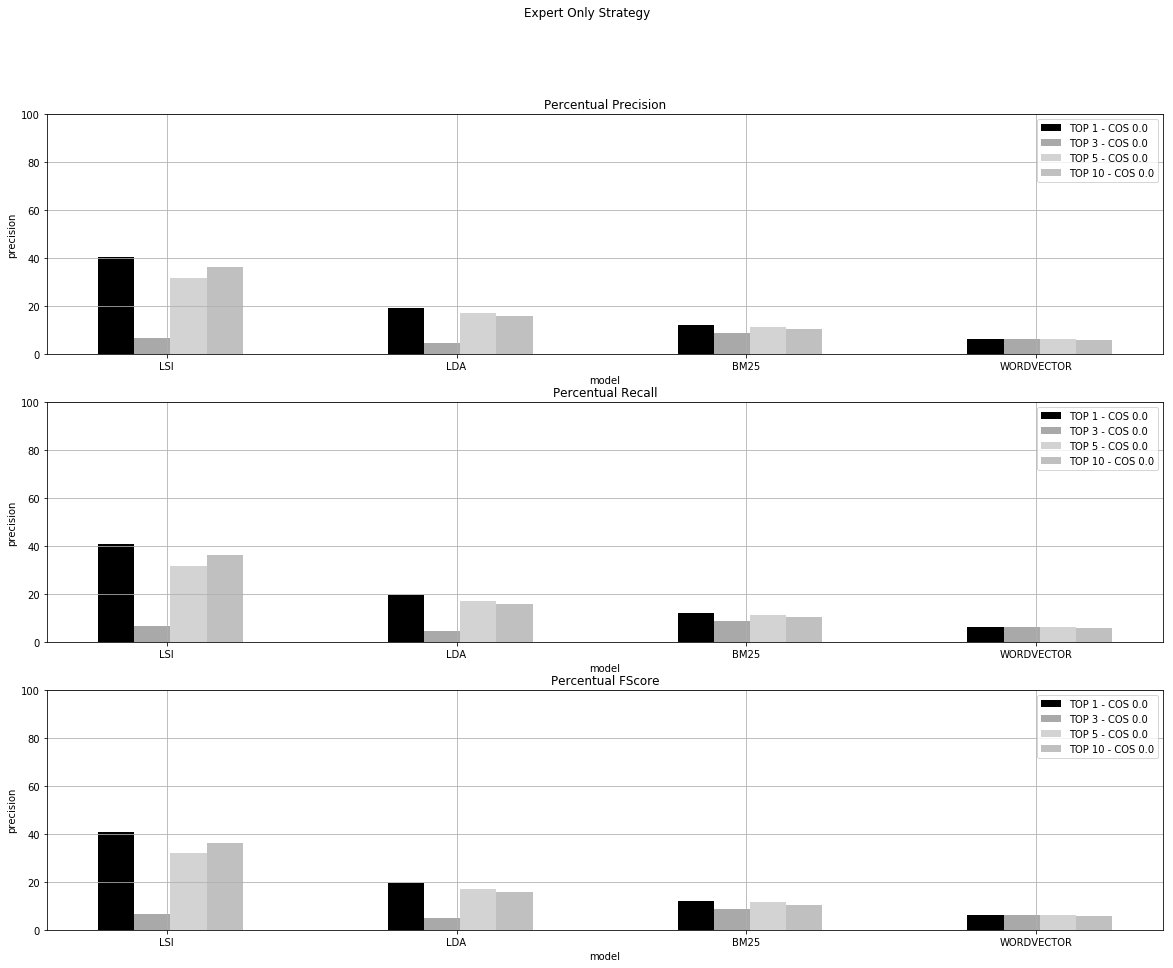

In [12]:
evaluator_3.plot_evaluations_1(evals_df=evals_df_3, title='Expert Only Strategy')

### Delete Variables

In [13]:
del lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3
del evals_df_3
del models_runner_3, evaluator_3

## Volunteers Only Strategy

In [14]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

evaluator_4 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [15]:
evals_df_4

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_3_cosine_0.0,18.32,47.31,25.23,precision recall fscore Bug_Nu...,0.0,3.0,Bug_Number 1248267 1248268 125...
2,lsi,top_5_cosine_0.0,12.53,52.06,19.24,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
3,lsi,top_10_cosine_0.0,7.91,60.94,13.32,precision recall fscore Bug_...,0.0,10.0,Bug_Number 1248267 1248268 125...
4,lda,top_1_cosine_0.0,14.29,11.76,12.45,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
5,lda,top_3_cosine_0.0,8.42,19.48,11.02,precision recall fscore Bug_Nu...,0.0,3.0,Bug_Number 1248267 1248268 125...
6,lda,top_5_cosine_0.0,11.65,48.41,18.01,precision recall fscore Bug_Nu...,0.0,5.0,Bug_Number 1248267 1248268 125...
7,lda,top_10_cosine_0.0,8.24,65.13,14.04,precision recall fscore Bug_...,0.0,10.0,Bug_Number 1248267 1248268 125...
8,bm25,top_1_cosine_0.0,25.27,23.43,23.69,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
9,bm25,top_3_cosine_0.0,16.48,43.57,23.04,precision recall fscore Bug_Nu...,0.0,3.0,Bug_Number 1248267 1248268 125...


### Plots

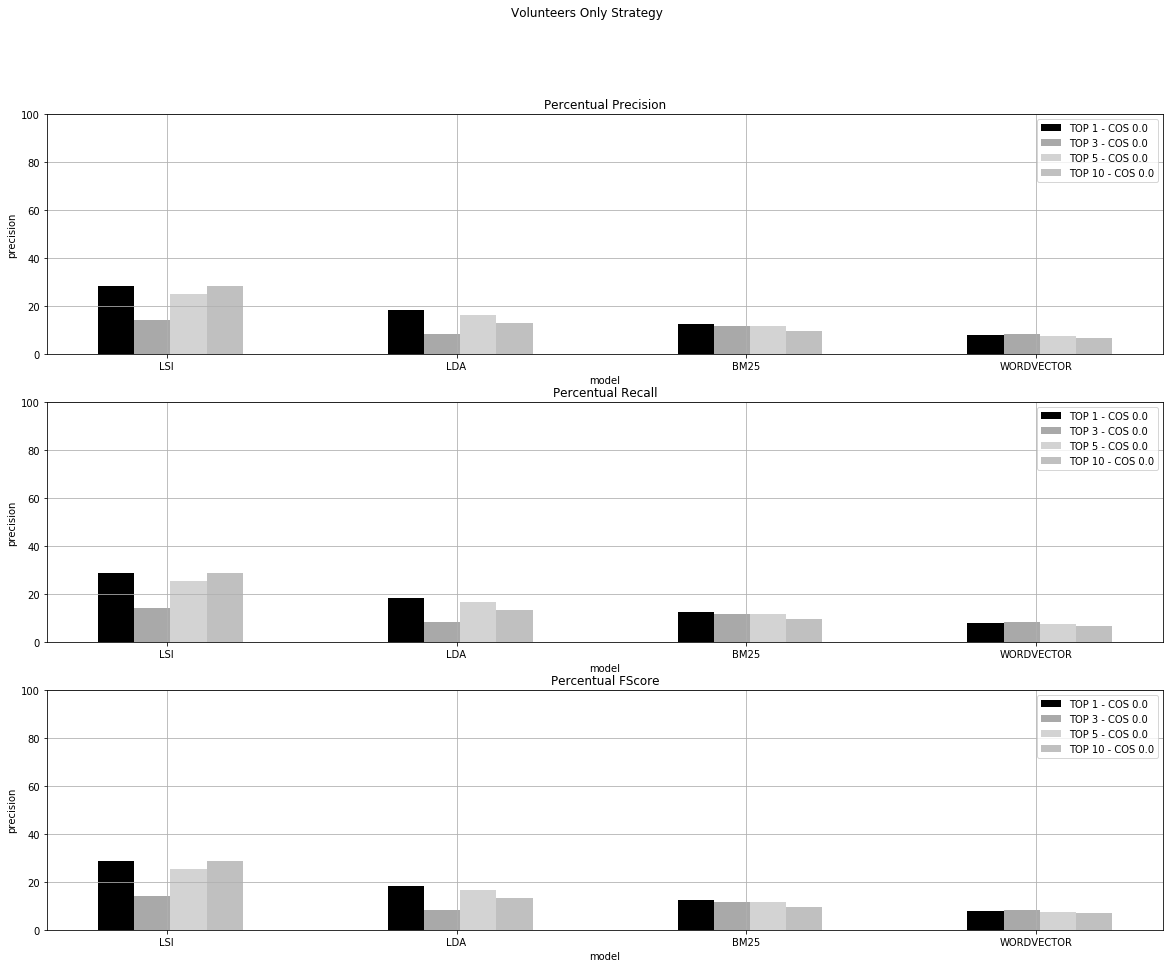

In [16]:
evaluator_4.plot_evaluations_1(evals_df=evals_df_4, title='Volunteers Only Strategy')

### Delete Variables

In [17]:
del lsi_model_4, lda_model_4, bm25_model_4, w2v_model_4
del evals_df_4
del models_runner_4, evaluator_4